In [132]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [133]:
df = pd.read_csv("shopping_trends.csv")

In [134]:
print(df.columns)

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Payment Method',
       'Shipping Type', 'Discount Applied', 'Promo Code Used',
       'Previous Purchases', 'Preferred Payment Method',
       'Frequency of Purchases'],
      dtype='object')


In [135]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [136]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [137]:
important_features = ["Category", "Purchase Amount (USD)", "Location", "Season", "Previous Purchases", "Frequency of Purchases"]
X = df[important_features]

y = df["Purchase Amount (USD)"]

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [139]:
# sales_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
# sales_model.fit(X_train, y_train)
sales_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,      # More trees for better learning
    learning_rate=0.05,    # Lower learning rate for stability
    max_depth=6,           # Control tree depth to prevent overfitting
    subsample=0.8,         # Use 80% of data per tree for regularization
    colsample_bytree=0.8,  # Use 80% of features per tree
    random_state=42
)


In [140]:
sales_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [141]:
y_pred_sales = sales_model.predict(X_test)

In [142]:
print("\n🔹 Sales Trends Forecasting Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_sales)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_sales)}")
print(f"R² Score: {r2_score(y_test, y_pred_sales)}")


🔹 Sales Trends Forecasting Performance:
MAE: 0.7324298620223999
MSE: 1.0514177083969116
R² Score: 0.9981210827827454


In [143]:
sales_pred = sales_model.predict(X_test)
print("Sales Prediction MSE:", mean_squared_error(y_test, sales_pred))


Sales Prediction MSE: 1.0514177083969116


In [144]:
print(df['Purchase Amount (USD)'].describe())


count    3900.000000
mean       59.764359
std        23.685392
min        20.000000
25%        39.000000
50%        60.000000
75%        81.000000
max       100.000000
Name: Purchase Amount (USD), dtype: float64


In [145]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Example: Customer data
customer_data = pd.DataFrame({
    'Customer ID': [1234],
    'Age': [30],
    'Gender': ['Male'],
    'Item Purchased': ['Product B'],
    'Category': ['Clothing'],
    'Location': ['Los Angeles'],
    'Size': ['L'],
    'Color': ['Blue'],
    'Season': ['Winter'],
    'Review Rating': [5],
    'Subscription Status': ['Active'],
    'Payment Method': ['PayPal'],
    'Shipping Type': ['Express'],
    'Discount Applied': [False],
    'Promo Code Used': [True],
    'Previous Purchases': [10],
    'Preferred Payment Method': ['Credit Card'],
    'Frequency of Purchases': [5]
})

# One-Hot Encoding for categorical columns
customer_data = pd.get_dummies(customer_data, drop_first=True)

# Step 1: Extract the feature names from the model
model_feature_names = sales_model.get_booster().feature_names

# Step 2: Align the input data with the model's expected feature names

# Create a DataFrame with columns from the model's feature names
aligned_data = pd.DataFrame(columns=model_feature_names)

# Fill the aligned data with values from the customer data where possible
for col in customer_data.columns:
    if col in aligned_data.columns:
        aligned_data[col] = customer_data[col]

# Step 3: Ensure all required features are present in the aligned data
# Fill missing columns with zeros (or use NaN if your model can handle it)
aligned_data = aligned_data.fillna(0)

# Step 4: Predict customer's future purchase amount
y_customer_pred = sales_model.predict(aligned_data)

print(f"Predicted Purchase Amount for Customer 1234: ${y_customer_pred[0]:.2f}")


Predicted Purchase Amount for Customer 1234: $24.33


C:\Users\saiashrita\AppData\Local\Temp\ipykernel_21752\459043654.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aligned_data = aligned_data.fillna(0)


In [146]:
df["Predicted_Amount"] = sales_model.predict(X)

In [147]:
# Compute Sales Per Season
seasonal_sales = df.groupby("Season")["Predicted_Amount"].sum().sort_values(ascending=False)

# Display Seasonal Trends
print("Sales by Season:")
print(seasonal_sales)


Sales by Season:
Season
0    60031.578125
1    58714.769531
3    58625.097656
2    55772.769531
Name: Predicted_Amount, dtype: float32


In [148]:
df["Total_Purchase"] = df.groupby("Customer ID")["Predicted_Amount"].transform("sum")


In [149]:

# Recreate the encoder and fit it on the original dataset
encoder = LabelEncoder()
df["Item Purchased"] = encoder.fit_transform(df["Item Purchased"])  # Encoding step

# Get the mapping back
item_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))

# Replace numbers with original names
df["Item Purchased"] = df["Item Purchased"].map(item_mapping)

# Check the result
print(df[["Item Purchased"]].head())

   Item Purchased
0               2
1              23
2              11
3              14
4               2


In [150]:
# Compute Sales Per Item
popular_items = df.groupby("Item Purchased")["Predicted_Amount"].sum().sort_values(ascending=False)

# Display Top 5 Selling Items
print("Top 5 Popular Items:")
print(popular_items.head(5))


Top 5 Popular Items:
Item Purchased
2     10426.342773
16    10337.475586
5     10312.915039
13    10087.345703
12    10009.652344
Name: Predicted_Amount, dtype: float32


In [151]:
# Check unique values in 'Item Purchased'
print(df["Item Purchased"].unique())


[ 2 23 11 14 20 16 18  4  7 17  5 19 22 13 10  9 12 24 15  8 21  0  1  3
  6]


In [152]:
dfs = pd.read_csv("shopping_trends.csv")

In [153]:
print(dfs["Item Purchased"].unique())


['Blouse' 'Sweater' 'Jeans' 'Sandals' 'Sneakers' 'Shirt' 'Shorts' 'Coat'
 'Handbag' 'Shoes' 'Dress' 'Skirt' 'Sunglasses' 'Pants' 'Jacket' 'Hoodie'
 'Jewelry' 'T-shirt' 'Scarf' 'Hat' 'Socks' 'Backpack' 'Belt' 'Boots'
 'Gloves']


In [154]:

# Recreate the encoder and fit it on the original dataset
encoder = LabelEncoder()
df["Item Purchased"] = encoder.fit_transform(df["Item Purchased"])  # Encoding step

# Get the mapping back
item_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))

# Replace numbers with original names
df["Item Purchased"] = df["Item Purchased"].map(item_mapping)

# Check the result
print(df[["Item Purchased"]].head())

   Item Purchased
0               2
1              23
2              11
3              14
4               2


Customer Segmentation using XGBoost

In [155]:
print("Dataset Preview:\n", df.head())
print("\nDataset Info:\n", df.info())



Dataset Preview:
    Customer ID  Age  Gender  Item Purchased  Category  Purchase Amount (USD)  \
0            1   55       1               2         1                     53   
1            2   19       1              23         1                     64   
2            3   50       1              11         1                     73   
3            4   21       1              14         2                     90   
4            5   45       1               2         1                     49   

   Location  Size  Color  Season  ...  Subscription Status  Payment Method  \
0        16     0      7       3  ...                    1               2   
1        18     0     12       3  ...                    1               0   
2        20     2     12       1  ...                    1               1   
3        38     1     12       1  ...                    1               4   
4        36     1     21       1  ...                    1               1   

   Shipping Type  Discount Appli

In [156]:
df = df.dropna()

In [157]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [158]:
print(df.columns)

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category',
       'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season',
       'Review Rating', 'Subscription Status', 'Payment Method',
       'Shipping Type', 'Discount Applied', 'Promo Code Used',
       'Previous Purchases', 'Preferred Payment Method',
       'Frequency of Purchases', 'Predicted_Amount', 'Total_Purchase'],
      dtype='object')


c:\Users\saiashrita\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.9987179487179487

Confusion Matrix:
 [[558   0]
 [  1 221]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       558
           1       1.00      1.00      1.00       222

    accuracy                           1.00       780
   macro avg       1.00      1.00      1.00       780
weighted avg       1.00      1.00      1.00       780



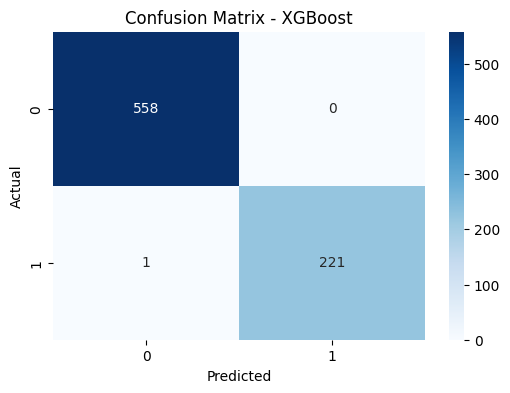

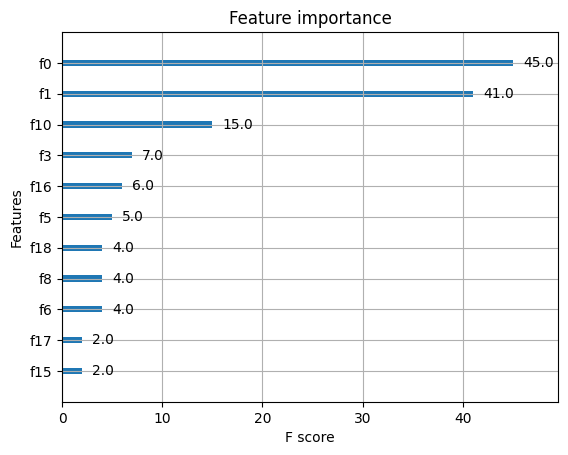

In [184]:


# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Feature Importance Plot
xgb.plot_importance(xgb_model)
plt.show()

In [187]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb

# Example new customer data
future_data = pd.DataFrame([{
    'Age': 30,
    'Gender': 'Female',
    'Item Purchased': 'Shoes',
    'Category': 'Footwear',
    'Purchase Amount (USD)': 150,
    'Location': 'Los Angeles',
    'Size': 'L',
    'Color': 'Black',
    'Season': 'Winter',
    'Review Rating': 4.2,
    'Payment Method': 'PayPal',
    'Shipping Type': 'Express',
    'Discount Applied': 'Yes',
    'Promo Code Used': 'No',
    'Previous Purchases': 8,
    'Preferred Payment Method': 'PayPal',
    'Frequency of Purchases': 'Medium'
}])

# Ensure all required columns exist in future_data
for col in X.columns:
    if col not in future_data:
        future_data[col] = 0  # Default value for missing numerical columns

# Encode categorical features using the trained LabelEncoders
for col in label_encoders:
    if col in future_data:
        future_data[col] = future_data[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else 0)

# Reorder columns to match training data
future_data = future_data[X.columns]  

# Convert all data to numeric type
future_data = future_data.apply(pd.to_numeric, errors='coerce')

# Standardize using the trained scaler
future_data_scaled = scaler.transform(future_data)

# Predict whether the customer will buy the product
future_prediction = xgb_model.predict(future_data_scaled)

# Output the result
print("Will Buy" if future_prediction[0] == 1 else "Will Not Buy")


Will Buy


🔹 Accuracy: 0.9987

🔹 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       558
           1       1.00      1.00      1.00       222

    accuracy                           1.00       780
   macro avg       1.00      1.00      1.00       780
weighted avg       1.00      1.00      1.00       780



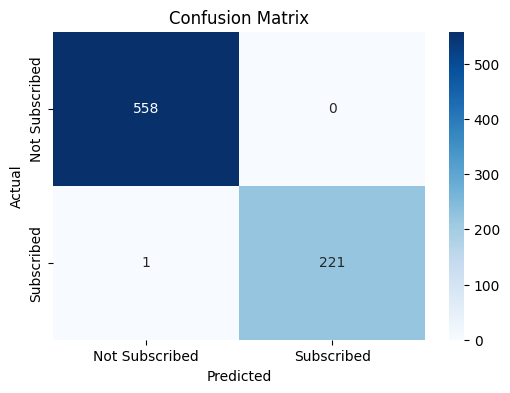

In [188]:
# Predictions on test data
y_pred = xgb_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"🔹 Accuracy: {accuracy:.4f}")

# Classification report
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Subscribed", "Subscribed"], yticklabels=["Not Subscribed", "Subscribed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()